<a href="https://colab.research.google.com/github/chris051091/Seminario-3/blob/master/preprocess/src/Testeo_Viento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testes - Viento (Dirección e intensidad)

In [101]:
import pandas as pd
import numpy as np
import os
import re
from functools import reduce

from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
PATH_DRIVE = 'drive/MyDrive/Seminario-3-master'
PATH_DADOS = '/preprocess/dados/'

# NOMBRE_ESTACION = 'chucuri'
# NOMBRE_ESTACION = 'palanquero'
NOMBRE_ESTACION = 'vizcaina'

PATH_FINAL_DADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/'
PATH_FINAL_DADOS_TRATADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/tratados/'

FILE_DATOS_PROCESADOS = NOMBRE_ESTACION.lower() + '_procesado_10min.csv'
FILE_DATOS_TRATADOS = NOMBRE_ESTACION.lower() + '_tratados_viento.csv'


In [103]:
df = pd.read_csv(PATH_FINAL_DADOS + FILE_DATOS_PROCESADOS, 
                 sep = ';', 
                 parse_dates = ["FECHA"],
                 date_parser = lambda col: pd.to_datetime(col)
                )

dfVar = df[['FECHA', 'VELVIENTO', 'DIRECVIENTO']].copy()
dfVar = dfVar.sort_values(by=['FECHA']).reset_index(drop = True)

# Eliminando datos que no fueron tomados cada 10 min.
# Para chucuri fueron 4 datos

dfVar = dfVar[dfVar['FECHA'].dt.minute % 10 == 0].reset_index(drop = True)
dfVar

,FECHA,VELVIENTO,DIRECVIENTO
0,2011-01-01 00:10:00-05:00,0.4,2.0
1,2011-01-01 00:20:00-05:00,0.5,7.0
2,2011-01-01 00:30:00-05:00,0.7,5.0
3,2011-01-01 00:40:00-05:00,0.9,6.0
4,2011-01-01 00:50:00-05:00,1.1,6.0
...,...,...,...
312925,2017-12-31 23:10:00-05:00,0.7,127.0
312926,2017-12-31 23:20:00-05:00,0.4,133.0
312927,2017-12-31 23:30:00-05:00,0.8,123.0
312928,2017-12-31 23:40:00-05:00,0.8,158.0


## Test de rango fijo

In [104]:
vel_max = 75.
vel_min = 0.
dir_max = 360.
dir_min = 0

lamb_func_vel = lambda r: np.nan if ((r > vel_max) | (r < vel_min)) else r
lamb_func_dir = lambda r: np.nan if ((r > dir_max) | (r < dir_min)) else r
lamb_func_null_vel = lambda r: np.nan if np.isnan(r['DIR_RANGO_FIJO']) else r['VEL_RANGO_FIJO']
lamb_func_null_dir = lambda r: np.nan if np.isnan(r['VEL_RANGO_FIJO']) else r['DIR_RANGO_FIJO']

dfVar['DIR_RANGO_FIJO'] = dfVar['DIRECVIENTO'].apply(lamb_func_dir)
dfVar['VEL_RANGO_FIJO'] = dfVar['VELVIENTO'].apply(lamb_func_vel)
dfVar['VEL_RANGO_FIJO'] = dfVar.apply(lamb_func_null_vel, axis=1)
dfVar['DIR_RANGO_FIJO'] = dfVar.apply(lamb_func_null_dir, axis=1)
dfVar

,FECHA,VELVIENTO,DIRECVIENTO,DIR_RANGO_FIJO,VEL_RANGO_FIJO
0,2011-01-01 00:10:00-05:00,0.4,2.0,2.0,0.4
1,2011-01-01 00:20:00-05:00,0.5,7.0,7.0,0.5
2,2011-01-01 00:30:00-05:00,0.7,5.0,5.0,0.7
3,2011-01-01 00:40:00-05:00,0.9,6.0,6.0,0.9
4,2011-01-01 00:50:00-05:00,1.1,6.0,6.0,1.1
...,...,...,...,...,...
312925,2017-12-31 23:10:00-05:00,0.7,127.0,127.0,0.7
312926,2017-12-31 23:20:00-05:00,0.4,133.0,133.0,0.4
312927,2017-12-31 23:30:00-05:00,0.8,123.0,123.0,0.8
312928,2017-12-31 23:40:00-05:00,0.8,158.0,158.0,0.8


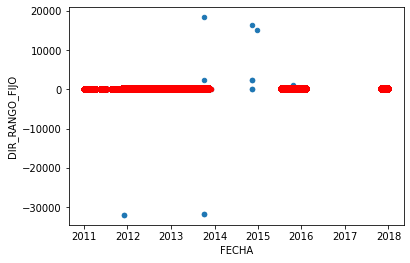

In [105]:
ax = dfVar.plot(kind = 'scatter', x='FECHA', y='DIRECVIENTO')
dfVar.plot(kind = 'scatter', x='FECHA', y='DIR_RANGO_FIJO', ax=ax, color='red')

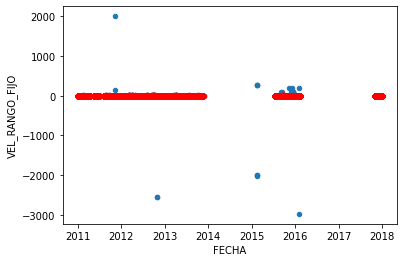

In [106]:
ax = dfVar.plot(kind = 'scatter', x='FECHA', y='VELVIENTO')
dfVar.plot(kind = 'scatter', x='FECHA', y='VEL_RANGO_FIJO', ax=ax, color='red')

In [107]:
dfVar['FECHA_DIA'] = dfVar['FECHA'].dt.date
dfVar['FECHA_HORA'] = dfVar['FECHA'].dt.hour


dfAux = (dfVar.groupby('FECHA_DIA')
       .agg({'DIR_RANGO_FIJO': ['mean', 'min', 'max'],
             'VEL_RANGO_FIJO': ['mean', 'min', 'max']}
            )
       .reset_index(level = [0])
)

check_size_list_2 = lambda r: 0 if ((np.isnan(r[-1])) | ((all([x == r[-1] for x in r])) & len(r) == 3)) else 1
check_size_list_5 = lambda r: 0 if ((np.isnan(r[-1])) | ((all([x == r[-1] for x in r])) & len(r) == 6)) else 1

dfAux = (dfAux.sort_values(by = 'FECHA_DIA'))

dfAux['VEL_PROM_D_1'] = (dfAux[('VEL_RANGO_FIJO', 'mean')].shift(1))
dfAux['DIR_PROM_D_1'] = (dfAux[('DIR_RANGO_FIJO', 'mean')].shift(1))

dfAux['VEL_PROM_LIST_D_2'] = [window.to_list() for window in dfAux[('VEL_RANGO_FIJO', 'mean')].rolling(window=3)]
dfAux['NO_REPETIDO_VEL_PROM_D_2'] = dfAux['VEL_PROM_LIST_D_2'].apply(check_size_list_2)

dfAux['VEL_MAX_LIST_D_2'] = [window.to_list() for window in dfAux[('VEL_RANGO_FIJO', 'max')].rolling(window=3)]
dfAux['NO_REPETIDO_VEL_MAX_D_2'] = dfAux['VEL_MAX_LIST_D_2'].apply(check_size_list_2)

dfAux['DIR_PROM_LIST_D_2'] = [window.to_list() for window in dfAux[('DIR_RANGO_FIJO', 'mean')].rolling(window=3)]
dfAux['NO_REPETIDO_DIR_PROM_D_2'] = dfAux['DIR_PROM_LIST_D_2'].apply(check_size_list_2)

dfCons = (pd.merge(dfVar,dfAux,on='FECHA_DIA', how='outer')
            .rename(columns = { ('DIR_RANGO_FIJO', 'mean') : 'DIR_PROM_DIARIA',
                                ('DIR_RANGO_FIJO', 'min') : 'DIR_MIN_DIARIA',
                                ('DIR_RANGO_FIJO', 'max') : 'DIR_MAX_DIARIA',
                                ('VEL_RANGO_FIJO', 'mean') : 'VEL_PROM_DIARIA',
                                ('VEL_RANGO_FIJO', 'min') : 'VEL_MIN_DIARIA',
                                ('VEL_RANGO_FIJO', 'max') : 'VEL_MAX_DIARIA',
                                ('VEL_PROM_D_1', ''): 'VEL_PROM_D_1',
                                ('DIR_PROM_D_1', ''): 'DIR_PROM_D_1',
                                ('NO_REPETIDO_VEL_PROM_D_2', ''): 'NO_REPETIDO_VEL_PROM_D_2',
                                ('NO_REPETIDO_VEL_MAX_D_2', ''): 'NO_REPETIDO_VEL_MAX_D_2',
                                ('NO_REPETIDO_DIR_PROM_D_2', ''): 'NO_REPETIDO_DIR_PROM_D_2',
                               })
        )

######################################################################################

dfAux2 = (dfVar.rename(columns = {'DIR_RANGO_FIJO' : 'DIR_RANGO_FIJO_MINUTO',
                                  'VEL_RANGO_FIJO' : 'VEL_RANGO_FIJO_MINUTO'})
              .groupby(['FECHA_DIA', 'FECHA_HORA'])
              .agg({'DIR_RANGO_FIJO_MINUTO': ['mean', 'min', 'max'],
                    'VEL_RANGO_FIJO_MINUTO': ['mean', 'min', 'max']}
                    )
              .reset_index(level = [0]).reset_index(level = [0])
)

dfAux2['VEL_PROM_H_1'] = (dfAux2[('VEL_RANGO_FIJO_MINUTO', 'mean')].shift(1))
dfAux2['DIR_PROM_H_1'] = (dfAux2[('DIR_RANGO_FIJO_MINUTO', 'mean')].shift(1))

dfAux2['VEL_PROM_LIST_H_5'] = [window.to_list() for window in dfAux2[('VEL_RANGO_FIJO_MINUTO', 'mean')].rolling(window=6)]
dfAux2['NO_REPETIDO_VEL_PROM_H_5'] = dfAux2['VEL_PROM_LIST_H_5'].apply(check_size_list_5)

dfAux2['DIR_PROM_LIST_H_5'] = [window.to_list() for window in dfAux2[('DIR_RANGO_FIJO_MINUTO', 'mean')].rolling(window=6)]
dfAux2['NO_REPETIDO_DIR_PROM_H_5'] = dfAux2['DIR_PROM_LIST_H_5'].apply(check_size_list_5)

dfCons = (pd.merge(dfCons,dfAux2, on=['FECHA_DIA', 'FECHA_HORA'], how='outer')
            .rename(columns = { ('DIR_RANGO_FIJO_MINUTO', 'mean') : 'DIR_PROM_HORA',
                                ('DIR_RANGO_FIJO_MINUTO', 'min') : 'DIR_MIN_HORA',
                                ('DIR_RANGO_FIJO_MINUTO', 'max') : 'DIR_MAX_HORA',
                                ('VEL_RANGO_FIJO_MINUTO', 'mean') : 'VEL_PROM_HORA',
                                ('VEL_RANGO_FIJO_MINUTO', 'min') : 'VEL_MIN_HORA',
                                ('VEL_RANGO_FIJO_MINUTO', 'max') : 'VEL_MAX_HORA',
                                ('VEL_PROM_H_1', ''): 'VEL_PROM_H_1',
                                ('DIR_PROM_H_1', ''): 'DIR_PROM_H_1',
                                ('NO_REPETIDO_VEL_PROM_H_5', ''): 'NO_REPETIDO_VEL_PROM_H_5',
                                ('NO_REPETIDO_DIR_PROM_H_5', ''): 'NO_REPETIDO_DIR_PROM_H_5',
                               })
         )

dfCons['FECHA_DIA'] = dfCons['FECHA_DIA'].apply(lambda x: x.strftime('%Y-%m-%d'))

dfCons['FORM_2_52'] = np.where(dfCons['VEL_MAX_DIARIA'] > dfCons['VEL_PROM_DIARIA'], 1, 0)

dfCons['DIR_NULL_ZERO'] = np.where((dfCons['DIR_RANGO_FIJO'] == 0.0) | (dfCons['DIR_RANGO_FIJO'].isnull()), 1, 0) # 1 cuando es 0 o nulo. 0 en los otros casos
dfCons['VEL_NULL_ZERO'] = np.where((dfCons['VEL_RANGO_FIJO'] == 0.0) | (dfCons['VEL_RANGO_FIJO'].isnull()), 1, 0) # 1 cuando es 0 o nulo. 0 en los otros casos

dfCons['FORM_2_54'] = np.where((dfCons['FORM_2_52'] == 1) &
                                (
                                 (dfCons['DIR_NULL_ZERO'] == 0.0) | 
                                 ((dfCons['DIR_NULL_ZERO'] == 1) & (dfCons['VEL_NULL_ZERO'] == 0))
                                ), 1, 0)

dfCons['FORM_2_55'] = np.where((dfCons['FORM_2_54'] == 1) &
                                (
                                 (dfCons['VEL_NULL_ZERO'] == 0.0) | 
                                 ((dfCons['VEL_NULL_ZERO'] == 1) & (dfCons['DIR_NULL_ZERO'] == 0))
                                ), 1, 0)

dfCons['FORM_2_56'] = np.where((dfCons['FORM_2_55'] == 1) &
                                ( abs(dfCons['VEL_PROM_DIARIA'] - dfCons['VEL_PROM_D_1']) < 10.0), 1, 0)

dfCons['FORM_2_57'] = np.where((dfCons['FORM_2_56'] == 1) &
                                ( abs(dfCons['VEL_PROM_HORA'] - dfCons['VEL_PROM_H_1']) < 7.5), 1, 0)

dfCons['DIR_ABS_D_1'] = abs(dfCons['DIR_PROM_DIARIA'] - dfCons['DIR_PROM_D_1'])
dfCons['DIR_ABS_D_1_360'] = 360.0 - abs(dfCons['DIR_PROM_DIARIA'] - dfCons['DIR_PROM_D_1'])
dfCons['DIR_ABS_H_1'] = abs(dfCons['DIR_PROM_HORA'] - dfCons['DIR_PROM_H_1'])
dfCons['DIR_ABS_H_1_360'] = 360.0 - abs(dfCons['DIR_PROM_HORA'] - dfCons['DIR_PROM_H_1'])
dfCons['MIN_DIR_ABS_D_1'] = dfCons[['DIR_ABS_D_1', 'DIR_ABS_D_1_360']].min(axis=1)
dfCons['MIN_DIR_ABS_H_1'] = dfCons[['DIR_ABS_H_1', 'DIR_ABS_H_1_360']].min(axis=1)

dfCons['FORM_2_58'] = np.where((dfCons['FORM_2_57'] == 1) &
                                ( dfCons['MIN_DIR_ABS_D_1'] < 150.0), 1, 0)

dfCons['FORM_2_59'] = np.where((dfCons['FORM_2_58'] == 1) &
                                ( dfCons['MIN_DIR_ABS_H_1'] < 150.0), 1, 0)

dfCons['FORM_2_60'] = np.where((dfCons['FORM_2_59'] == 1) & (dfCons['NO_REPETIDO_VEL_PROM_D_2'] == 1), 1, 0)
dfCons['FORM_2_61'] = np.where((dfCons['FORM_2_60'] == 1) & (dfCons['NO_REPETIDO_VEL_MAX_D_2'] == 1), 1, 0)
dfCons['FORM_2_62'] = np.where((dfCons['FORM_2_61'] == 1) & (dfCons['NO_REPETIDO_DIR_PROM_D_2'] == 1), 1, 0)
dfCons['FORM_2_63'] = np.where((dfCons['FORM_2_62'] == 1) & (dfCons['NO_REPETIDO_VEL_PROM_H_5'] == 1), 1, 0)
dfCons['FORM_2_64'] = np.where((dfCons['FORM_2_63'] == 1) & (dfCons['NO_REPETIDO_DIR_PROM_H_5'] == 1), 1, 0)

####  Quedamos en la formula 2.64 #####

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [108]:
## Para filtrar los valores finales
dfFinal = dfCons[dfCons['FORM_2_64'] == 1].reset_index(drop=True)
dfFinal 

,FECHA,VELVIENTO,DIRECVIENTO,DIR_RANGO_FIJO,VEL_RANGO_FIJO,FECHA_DIA,FECHA_HORA,DIR_PROM_DIARIA,DIR_MIN_DIARIA,DIR_MAX_DIARIA,VEL_PROM_DIARIA,VEL_MIN_DIARIA,VEL_MAX_DIARIA,VEL_PROM_D_1,DIR_PROM_D_1,"(VEL_PROM_LIST_D_2, )",NO_REPETIDO_VEL_PROM_D_2,"(VEL_MAX_LIST_D_2, )",NO_REPETIDO_VEL_MAX_D_2,"(DIR_PROM_LIST_D_2, )",NO_REPETIDO_DIR_PROM_D_2,DIR_PROM_HORA,DIR_MIN_HORA,DIR_MAX_HORA,VEL_PROM_HORA,VEL_MIN_HORA,VEL_MAX_HORA,VEL_PROM_H_1,DIR_PROM_H_1,"(VEL_PROM_LIST_H_5, )",NO_REPETIDO_VEL_PROM_H_5,"(DIR_PROM_LIST_H_5, )",NO_REPETIDO_DIR_PROM_H_5,FORM_2_52,DIR_NULL_ZERO,VEL_NULL_ZERO,FORM_2_54,FORM_2_55,FORM_2_56,FORM_2_57,DIR_ABS_D_1,DIR_ABS_D_1_360,DIR_ABS_H_1,DIR_ABS_H_1_360,MIN_DIR_ABS_D_1,MIN_DIR_ABS_H_1,FORM_2_58,FORM_2_59,FORM_2_60,FORM_2_61,FORM_2_62,FORM_2_63,FORM_2_64
0,2011-01-02 00:00:00-05:00,0.4,9.0,9.0,0.4,2011-01-02,0,8.493056,1.0,16.0,0.901389,0.3,2.4,0.755944,8.804196,"[0.755944055944056, 0.901388888888889]",1,"[1.9, 2.4]",1,"[8.804195804195805, 8.493055555555555]",1,5.833333,1.0,9.0,0.600000,0.3,0.9,0.550000,8.666667,"[0.45, 0.6666666666666666, 0.3666666666666667,...",1,"[8.666666666666666, 7.5, 6.666666666666667, 8....",1,1,0,0,1,1,1,1,0.311140,359.688860,2.833333,357.166667,0.311140,2.833333,1,1,1,1,1,1,1
1,2011-01-02 00:10:00-05:00,0.7,7.0,7.0,0.7,2011-01-02,0,8.493056,1.0,16.0,0.901389,0.3,2.4,0.755944,8.804196,"[0.755944055944056, 0.901388888888889]",1,"[1.9, 2.4]",1,"[8.804195804195805, 8.493055555555555]",1,5.833333,1.0,9.0,0.600000,0.3,0.9,0.550000,8.666667,"[0.45, 0.6666666666666666, 0.3666666666666667,...",1,"[8.666666666666666, 7.5, 6.666666666666667, 8....",1,1,0,0,1,1,1,1,0.311140,359.688860,2.833333,357.166667,0.311140,2.833333,1,1,1,1,1,1,1
2,2011-01-02 00:20:00-05:00,0.9,6.0,6.0,0.9,2011-01-02,0,8.493056,1.0,16.0,0.901389,0.3,2.4,0.755944,8.804196,"[0.755944055944056, 0.901388888888889]",1,"[1.9, 2.4]",1,"[8.804195804195805, 8.493055555555555]",1,5.833333,1.0,9.0,0.600000,0.3,0.9,0.550000,8.666667,"[0.45, 0.6666666666666666, 0.3666666666666667,...",1,"[8.666666666666666, 7.5, 6.666666666666667, 8....",1,1,0,0,1,1,1,1,0.311140,359.688860,2.833333,357.166667,0.311140,2.833333,1,1,1,1,1,1,1
3,2011-01-02 00:30:00-05:00,0.8,6.0,6.0,0.8,2011-01-02,0,8.493056,1.0,16.0,0.901389,0.3,2.4,0.755944,8.804196,"[0.755944055944056, 0.901388888888889]",1,"[1.9, 2.4]",1,"[8.804195804195805, 8.493055555555555]",1,5.833333,1.0,9.0,0.600000,0.3,0.9,0.550000,8.666667,"[0.45, 0.6666666666666666, 0.3666666666666667,...",1,"[8.666666666666666, 7.5, 6.666666666666667, 8....",1,1,0,0,1,1,1,1,0.311140,359.688860,2.833333,357.166667,0.311140,2.833333,1,1,1,1,1,1,1
4,2011-01-02 00:40:00-05:00,0.5,6.0,6.0,0.5,2011-01-02,0,8.493056,1.0,16.0,0.901389,0.3,2.4,0.755944,8.804196,"[0.755944055944056, 0.901388888888889]",1,"[1.9, 2.4]",1,"[8.804195804195805, 8.493055555555555]",1,5.833333,1.0,9.0,0.600000,0.3,0.9,0.550000,8.666667,"[0.45, 0.6666666666666666, 0.3666666666666667,...",1,"[8.666666666666666, 7.5, 6.666666666666667, 8....",1,1,0,0,1,1,1,1,0.311140,359.688860,2.833333,357.166667,0.311140,2.833333,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144294,2017-12-31 23:10:00-05:00,0.7,127.0,127.0,0.7,2017-12-31,23,172.729167,0.0,359.0,0.772222,0.2,1.7,0.947917,146.743056,"[0.7791666666666668, 0.9479166666666669, 0.772...",1,"[2.8, 3.4, 1.7]",1,"[196.14583333333334, 146.74305555555554, 172.7...",1,157.500000,123.0,207.0,0.583333,0.2,0.8,0.583333,245.833333,"[0.39999999999999997, 0.4666666666666666, 0.51...",1,"[258.5, 143.16666666666666, 168.16666666666666...",1,1,0,0,1,1,1,1,25.986111,334.013889,88.333333,271.666667,25.986111,88.333333,1,1,1,1,1,1,1
144295,2017-12-31 23:20:00-05:00,0.4,133.0,133.0,0.4,2017-12-31,23,172.729167,0.0,359.0,0.772222,0.2,1.7,0.947917,146.743056,"[0.7791666666666668, 0.9479166666666669, 0.772...",1,"[2.8, 3.4, 1.7]",1,"[196.

In [109]:
print(f'Datos iniciales : {dfVar.shape[0]}')
print(f'Datos nulos iniciales : {dfVar[(dfVar["DIRECVIENTO"].isnull()) | (dfVar["VELVIENTO"].isnull())].shape[0]}')
print(f'Datos nulos después de los testes : {dfFinal[(dfFinal["DIR_RANGO_FIJO"].isnull()) | (dfFinal["VEL_RANGO_FIJO"].isnull())].shape[0]}')
print(f'Datos finales después de testes : {dfFinal.shape[0]}')
print(f'Datos no nulos que fueron eliminados en los testes : {dfVar.shape[0] - dfFinal.shape[0] - dfVar[(dfVar["DIRECVIENTO"].isnull()) | (dfVar["VELVIENTO"].isnull())].shape[0]}')

Datos iniciales : 312930
Datos nulos iniciales : 158904
Datos nulos después de los testes : 0
Datos finales después de testes : 144299
Datos no nulos que fueron eliminados en los testes : 9727


In [110]:
(dfFinal[['FECHA', 'DIR_RANGO_FIJO', 'VEL_RANGO_FIJO']]
          .rename(columns = {'DIR_RANGO_FIJO' : 'DIRECVIENTO',
                                  'VEL_RANGO_FIJO' : 'VELVIENTO'})
          .to_csv(PATH_FINAL_DADOS_TRATADOS + FILE_DATOS_TRATADOS, header=True, index=False, sep = ';'))